# Merging Documents to Obtain a Complete View of Hadreen's Community Kitchen and Clusters
## Objective:

The goal is to merge multiple documents to create a comprehensive dataset on Hadreen's community kitchens and their associated clusters. The final output will include detailed information about each kitchen, its locality, state, and cluster assignments.

## Documents Involved:

The necessary documents are contained in the Kitchen Admin Documents folder. These documents will be merged to form the final dataset:

- CK List
    This document provides a list of community kitchens with key features:

        N: Kitchen number

        ID: Kitchen ID (formatted as State/Locality/Number)

        State: Admin1 level (State/Province)

        Locality: Specific locality or region within the state

        District/Area: Name of the kitchen's district or area


- Kitchen Grouping List
    This document contains data related to kitchen groupings and clusters:

        Batch Sheet: Contains kitchen IDs used across different forms

        Cashflow Sheet: Contains information about the different clusters associated with the kitchens



## Libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## Code

In [2]:
#Read the excel file CK
ck_list = pd.read_excel('../../1. Data available/ISHTM_Hadhreen/Kitchen Admin Documents/CK List.xlsx')
# Extract column
ck_list = ck_list[['ID', 'State', 'Locality', 'District / Area']]
# Rename column
ck_list.columns = ['kitchen_code', 'kitchen_state', 'kitchen_locality', 'kitchen_area']
# Remove space in kitchen_code
ck_list['kitchen_code'] = ck_list['kitchen_code'].str.strip()
ck_list['kitchen_code'] = [code.replace("/MA/","/JA/") for code in ck_list['kitchen_code']]
ck_list.head()

##Kitchen not in service
kitchen_to_be_removed = ['KH/JA/184', 'KH/JA/185', 'KH/JA/186', 'KH/JA/187', 'KH/JA/188', 'KH/JA/189', 'KH/JA/190', 'KH/JA/191',
                         'KH/JA/192', 'KH/JA/193', 'KH/JA/194', 'KH/JA/195', 'KH/JA/196', 'KH/JA/197', 'KH/JA/198', 'KH/JA/199',
                         'KH/JA/200', 'KH/JA/201', 'KH/JA/202', 'KH/JA/203', 'KH/JA/204', 'KH/JA/205', 'KH/JA/206', 'KH/JA/207',
                         'KH/JA/208', 'KH/JA/209', 'KH/JA/210', 'KH/JA/211', 'KH/JA/212', 'KH/JA/213', 'KH/JA/214', 'KH/JA/215',
                         'KH/JA/216', 'KH/JA/217', 'KH/JA/218', 'KH/JA/219', 'KH/JA/220', 'KH/JA/221', 'KH/JA/222', 'KH/JA/223',
                         'KH/JA/224', 'KH/JA/225', 'KH/JA/226', 'KH/JA/227', 'KH/JA/228', 'KH/JA/229', 'KH/JA/230', 'KH/JA/231',
                         'KH/JA/232', 'KH/JA/233', 'KH/JA/234', 'KH/JA/235', 'KH/JA/236', 'KH/JA/237', 'KH/JA/135', 'KH/JA/136',
                         'KH/JA/137', 'KH/JA/138', 'KH/JA/139', 'KH/JA/140', 'KH/JA/141', 'KH/JA/142', 'KH/JA/143', 'KH/JA/148']

# Remocve then from this list
ck_list = ck_list[~ck_list['kitchen_code'].isin(kitchen_to_be_removed)]
print(len(ck_list))

184


In [3]:
# Read the excel file Kitchen Grouping List - First sheet 
grouping_batch = pd.read_excel('../../1. Data available/ISHTM_Hadhreen/Kitchen Admin Documents/Kitchen Grouping list.xlsx', sheet_name='batch')
# Extract column we need
grouping_batch = grouping_batch[['Kitchen Name', 'Kitchen ID']]
## Rename column 
grouping_batch.columns = ['kitchen_cluster_name', 'kitchen_cluster_id']
##Remove na values
grouping_batch = grouping_batch.dropna(how='all')
## Remove space from kitchen_cluster_id
grouping_batch['kitchen_cluster_id'] = grouping_batch['kitchen_cluster_id'].str.strip()
## Remove duplicate in the list
grouping_batch = grouping_batch.drop_duplicates()
## For each cluster list the kitchen_code containing
list_final_code = []
for index, row in grouping_batch.iterrows():
    cluster_id = row['kitchen_cluster_id']
    if '-' in cluster_id:
        codes_ = cluster_id.split('/')[2]
        codes_ = codes_.replace('(', '').replace(')', '').split('-')
        codes_ = [int(code) for code in codes_]
        list_codes = [cluster_id.split('/')[0] + '/' + cluster_id.split('/')[1] + '/' + str(item) for item in range(min(codes_), max(codes_)+1)]
        list_final_code.append(list_codes)
    elif ',' in cluster_id:
        codes_ = cluster_id.split('/')[2]
        codes_ = codes_.split(',')
        list_codes = [cluster_id.split('/')[0] + '/' + cluster_id.split('/')[1] + '/' + str(item) for item in codes_]
        list_final_code.append(list_codes)
    elif len(cluster_id.split('/')) > 3:
        codes_ = [cluster_id.split('/')[2], cluster_id.split('/')[3]]
        codes_ = [int(code) for code in codes_]
        list_codes = [cluster_id.split('/')[0] + '/' + cluster_id.split('/')[1] + '/' + str(item) for item in codes_]
        list_final_code.append(list_codes)
    else:
        list_final_code.append([cluster_id])

## now we can save this list into the data
grouping_batch['kitchen_list_codes'] = list_final_code 

## and then explode the line to allow the match
grouping_batch = grouping_batch.explode('kitchen_list_codes', ignore_index=True)
grouping_batch.columns = ['kitchen_cluster_name', 'kitchen_cluster_id', 'kitchen_code']

grouping_batch['kitchen_code'] = [code.replace("/MA/","/JA/") for code in grouping_batch['kitchen_code']]

## Remove duplicates -- Kitchen KH/SH/35 appears two times with same cluster_name
grouping_batch = grouping_batch.drop_duplicates(subset=['kitchen_cluster_name', 'kitchen_code'], keep='first')

In [4]:
## Now we can merge both list
final_restults = pd.merge(ck_list, grouping_batch, on='kitchen_code', how='left')
##Chnage mayo to Jabel Awlia 
final_restults.loc[final_restults['kitchen_locality'] == 'Mayo', 'kitchen_locality'] = 'Jebel Awlia'
final_restults = final_restults.drop_duplicates(subset=['kitchen_code'], keep='first')
final_restults.to_excel('../output/kitchen_ids_cluster.xlsx', index = False)   

## Visualization

In [5]:
kitchen_ids_vis = pd.read_excel('../output/kitchen_ids_cluster.xlsx')
print(len(kitchen_ids_vis))
kitchen_ids_vis = kitchen_ids_vis.drop_duplicates(subset=['kitchen_code'], keep='first')
print(len(kitchen_ids_vis))

184
184


<ipython-input-6-29f98ee80c47>:9: UserWarning: The palette list has more values (10) than needed (1), which may not be intended.
  barplot = sns.barplot(data=grouped_df, x='kitchen_locality', y='KitchenCount', hue='kitchen_state', errorbar=None,


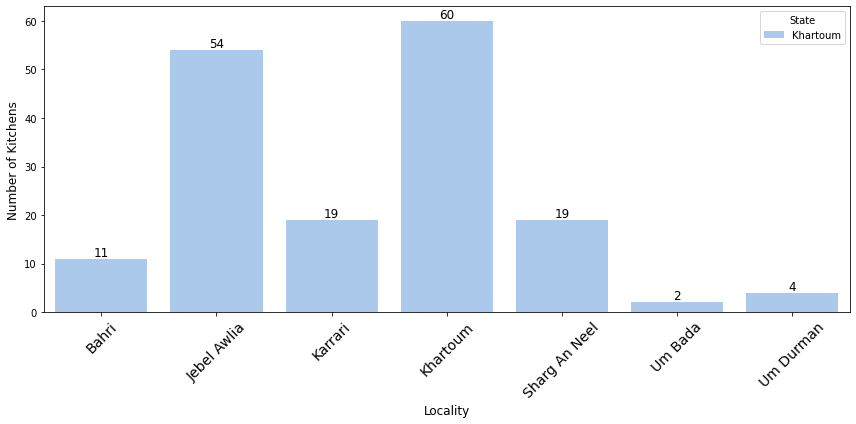

In [6]:
# Count number of kitchens per locality
grouped_df = kitchen_ids_vis.groupby(['kitchen_state', 'kitchen_locality']).size().reset_index(name='KitchenCount')

# Sort the DataFrame by translated_location alphabetically
grouped_df = grouped_df.sort_values(by='kitchen_locality')

# Plot using seaborn
plt.figure(figsize=(12, 6))
barplot = sns.barplot(data=grouped_df, x='kitchen_locality', y='KitchenCount', hue='kitchen_state', errorbar=None,
    palette=sns.color_palette("pastel") # Set the color to bisque
                     )
barplot.bar_label(barplot.containers[0], fontsize=12)
plt.xlabel('Locality', fontsize=12)
plt.ylabel('Number of Kitchens', fontsize=12)
plt.legend(title='State', loc='upper right')
plt.xticks(rotation=45, fontsize=14)
plt.tight_layout()
plt.savefig('../visualization/kitchen_locality.png', dpi=300)
# Show plot
plt.show()

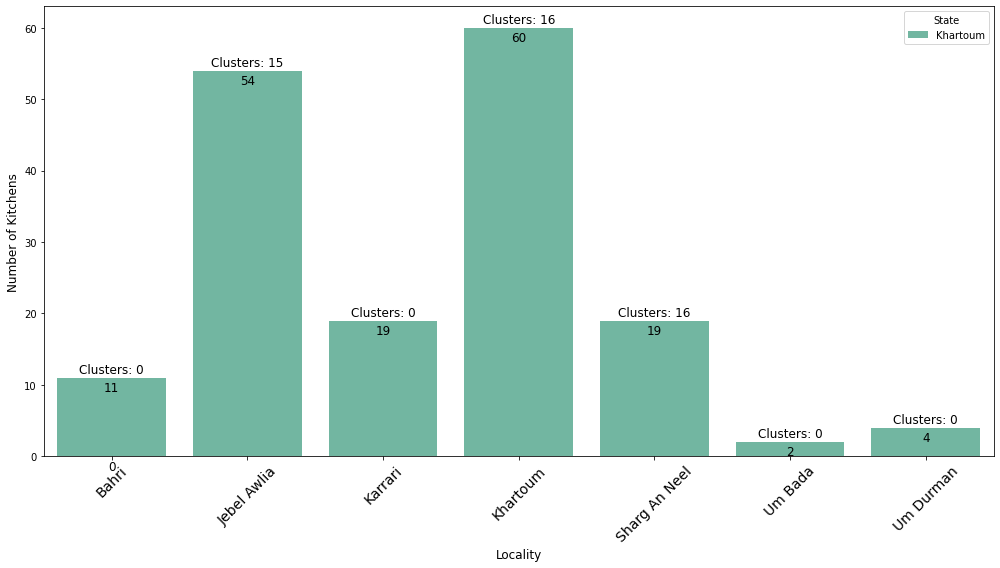

In [7]:
# Group by state and locality
grouped_df = kitchen_ids_vis.groupby(['kitchen_state', 'kitchen_locality']).agg(
    KitchenCount=('kitchen_locality', 'count'),  # Count number of kitchens
    ClusterCount=('kitchen_cluster_name', 'nunique')   # Count unique clusters
).reset_index()

# Plot using seaborn
plt.figure(figsize=(14, 8))
barplot = sns.barplot(
    data=grouped_df,
    x='kitchen_locality',
    y='KitchenCount',
    hue='kitchen_state',
    palette='Set2',
    dodge=True
)

# Add cluster count annotations
for i, row in grouped_df.iterrows():
    x = i  # Index matches the bar index
    y = row['KitchenCount']
    cluster_count = row['ClusterCount']
    plt.text(x, y + 0.2, f"Clusters: {cluster_count}", ha='center', va='bottom', fontsize=12, color='black')
    
    # Add numbers inside the bars
for bar in barplot.patches:
    # Get the x and y position of the bar
    x = bar.get_x() + bar.get_width() / 2
    y = bar.get_height()
    # Add text at the center of the bar
    plt.text(x=x, y=y - 0.5, s=int(y), ha='center', va='top', color='black', fontsize=12)


# Customize plot
plt.xlabel('Locality', fontsize=12)
plt.ylabel('Number of Kitchens', fontsize=12)
plt.legend(title='State', loc='upper right')
plt.xticks(rotation=45, fontsize=14)
plt.tight_layout()

plt.savefig('../visualization/kitchen_locality_with_clusters.png', dpi=300)
# Show plot
plt.show()